In [1]:
import os
import sys
from PIL import Image
import tensorflow as tf
import deeplab_model
from utils import preprocessing
from tensorflow.python import debug as tf_debug
import random
import shutil
import numpy as np
from tensorflow.contrib import layers as layers_lib
from tensorflow.contrib.slim.nets import resnet_v2
from tensorflow.contrib.framework.python.ops import arg_scope
from tensorflow.contrib.layers.python.layers import layers
from matplotlib import pyplot as plt

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expect

In [2]:
_NUM_CLASSES = 21
_HEIGHT = 513
_WIDTH = 513
_DEPTH = 3
_MIN_SCALE = 0.5
_MAX_SCALE = 2.0
_IGNORE_LABEL = 255

_POWER = 0.9
_MOMENTUM = 0.9

_BATCH_NORM_DECAY = 0.9997

_NUM_IMAGES = {
    'train': 10582,
    'validation': 1449,
}

_BATCH_NORM_DECAY = 0.9997
_WEIGHT_DECAY = 5e-4

In [3]:
model_dir = './model'
clean_model_dir = False
train_epochs = 26
epochs_per_eval = 1
tensorboard_images_max_outputs =6
batch_size = 8
learning_rate_policy = 'poly'
max_iter = 30000
data_dir = './dataset/'
base_architecture = 'resnet_v2_101'
pre_trained_model = './resnet_v2_101/resnet_v2_101.ckpt'
output_stride = 16
initial_learning_rate = 7e-3
end_learning_rate = 1e-6
initial_global_step = 0
weight_decay = 2e-4
debug = False
freeze_batch_norm = False

In [4]:
params={
      'output_stride': output_stride,
      'batch_size': batch_size,
      'base_architecture': base_architecture,
      'pre_trained_model': pre_trained_model,
      'batch_norm_decay': _BATCH_NORM_DECAY,
      'num_classes': _NUM_CLASSES,
      'tensorboard_images_max_outputs': tensorboard_images_max_outputs,
      'weight_decay': weight_decay,
      'learning_rate_policy': learning_rate_policy,
      'num_train': _NUM_IMAGES['train'],
      'initial_learning_rate': initial_learning_rate,
      'max_iter': max_iter,
      'end_learning_rate': end_learning_rate,
      'power': _POWER,
      'momentum': _MOMENTUM,
      'freeze_batch_norm': freeze_batch_norm,
      'initial_global_step': initial_global_step
  }

In [5]:
def atrous_spatial_pyramid_pooling(inputs, output_stride, batch_norm_decay, is_training, depth=256):
  """Atrous Spatial Pyramid Pooling.

  Args:
    inputs: A tensor of size [batch, height, width, channels].
    output_stride: The ResNet unit's stride. Determines the rates for atrous convolution.
      the rates are (6, 12, 18) when the stride is 16, and doubled when 8.
    batch_norm_decay: The moving average decay when estimating layer activation
      statistics in batch normalization.
    is_training: A boolean denoting whether the input is for training.
    depth: The depth of the ResNet unit output.

  Returns:
    The atrous spatial pyramid pooling output.
  """
  with tf.variable_scope("aspp"):
    if output_stride not in [8, 16]:
      raise ValueError('output_stride must be either 8 or 16.')

    atrous_rates = [6, 12, 18]
    if output_stride == 8:
      atrous_rates = [2*rate for rate in atrous_rates]

    with tf.contrib.slim.arg_scope(resnet_v2.resnet_arg_scope(batch_norm_decay=batch_norm_decay)):
      with arg_scope([layers.batch_norm], is_training=is_training):
        inputs_size = tf.shape(inputs)[1:3]
        # (a) one 1x1 convolution and three 3x3 convolutions with rates = (6, 12, 18) when output stride = 16.
        # the rates are doubled when output stride = 8.
        conv_1x1 = layers_lib.conv2d(inputs, depth, [1, 1], stride=1, scope="conv_1x1")
        conv_3x3_1 = layers_lib.conv2d(inputs, depth, [3, 3], stride=1, rate=atrous_rates[0], scope='conv_3x3_1')
        conv_3x3_2 = layers_lib.conv2d(inputs, depth, [3, 3], stride=1, rate=atrous_rates[1], scope='conv_3x3_2')
        conv_3x3_3 = layers_lib.conv2d(inputs, depth, [3, 3], stride=1, rate=atrous_rates[2], scope='conv_3x3_3')

        # (b) the image-level features
        with tf.variable_scope("image_level_features"):
          # global average pooling
          image_level_features = tf.reduce_mean(inputs, [1, 2], name='global_average_pooling', keepdims=True)
          # 1x1 convolution with 256 filters( and batch normalization)
          image_level_features = layers_lib.conv2d(image_level_features, depth, [1, 1], stride=1, scope='conv_1x1')
          # bilinearly upsample features
          image_level_features = tf.image.resize_bilinear(image_level_features, inputs_size, name='upsample')

        net = tf.concat([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, image_level_features], axis=3, name='concat')
        net = layers_lib.conv2d(net, depth, [1, 1], stride=1, scope='conv_1x1_concat')

        return net

In [6]:
def deeplab_v3_plus_generator(num_classes,
                              output_stride,
                              base_architecture,
                              pre_trained_model,
                              batch_norm_decay,
                              data_format='channels_last'):
    """Generator for DeepLab v3 plus models.

    Args:
    num_classes: The number of possible classes for image classification.
    output_stride: The ResNet unit's stride. Determines the rates for atrous convolution.
      the rates are (6, 12, 18) when the stride is 16, and doubled when 8.
    base_architecture: The architecture of base Resnet building block.
    pre_trained_model: The path to the directory that contains pre-trained models.
    batch_norm_decay: The moving average decay when estimating layer activation
      statistics in batch normalization.
    data_format: The input format ('channels_last', 'channels_first', or None).
      If set to None, the format is dependent on whether a GPU is available.
      Only 'channels_last' is supported currently.

    Returns:
    The model function that takes in `inputs` and `is_training` and
    returns the output tensor of the DeepLab v3 model.
    """
    if data_format is None:
    # data_format = (
    #     'channels_first' if tf.test.is_built_with_cuda() else 'channels_last')
        pass

    if batch_norm_decay is None:
        batch_norm_decay = _BATCH_NORM_DECAY

    if base_architecture not in ['resnet_v2_50', 'resnet_v2_101']:
        raise ValueError("'base_architrecture' must be either 'resnet_v2_50' or 'resnet_v2_101'.")

    if base_architecture == 'resnet_v2_50':
        base_model = resnet_v2.resnet_v2_50
    else:
        base_model = resnet_v2.resnet_v2_101

    def model(inputs, is_training):
        """Constructs the ResNet model given the inputs."""
        if data_format == 'channels_first':
          # Convert the inputs from channels_last (NHWC) to channels_first (NCHW).
          # This provides a large performance boost on GPU. See
          # https://www.tensorflow.org/performance/performance_guide#data_formats
            inputs = tf.transpose(inputs, [0, 3, 1, 2])

        # tf.logging.info('net shape: {}'.format(inputs.shape))
        # encoder
        with tf.contrib.slim.arg_scope(resnet_v2.resnet_arg_scope(batch_norm_decay=batch_norm_decay)):
            logits, end_points = base_model(inputs,
                                          num_classes=None,
                                          is_training=is_training,
                                          global_pool=False,
                                          output_stride=output_stride)
        ##get resnet pre-trained models from ckpt
#         if is_training:
#         exclude = [base_architecture + '/logits', 'global_step']
#         variables_to_restore = tf.contrib.slim.get_variables_to_restore(exclude=exclude)
#         tf.train.init_from_checkpoint(pre_trained_model,
#                                     {v.name.split(':')[0]: v for v in variables_to_restore})

        inputs_size = tf.shape(inputs)[1:3]
        net = end_points[base_architecture + '/block4']
        encoder_output = atrous_spatial_pyramid_pooling(net, output_stride, batch_norm_decay, is_training)

        with tf.variable_scope("decoder"):
            with tf.contrib.slim.arg_scope(resnet_v2.resnet_arg_scope(batch_norm_decay=batch_norm_decay)):
                with arg_scope([layers.batch_norm], is_training=is_training):
                    with tf.variable_scope("low_level_features"):
                        low_level_features = end_points[base_architecture + '/block1/unit_3/bottleneck_v2/conv1']
                        low_level_features = layers_lib.conv2d(low_level_features, 48,
                                                               [1, 1], stride=1, scope='conv_1x1')
                        low_level_features_size = tf.shape(low_level_features)[1:3]

                    with tf.variable_scope("upsampling_logits"):
                        net = tf.image.resize_bilinear(encoder_output, low_level_features_size, name='upsample_1')
                        net = tf.concat([net, low_level_features], axis=3, name='concat')
                        net = layers_lib.conv2d(net, 256, [3, 3], stride=1, scope='conv_3x3_1')
                        net = layers_lib.conv2d(net, 256, [3, 3], stride=1, scope='conv_3x3_2')
                        net = layers_lib.conv2d(net, num_classes, [1, 1], activation_fn=None, normalizer_fn=None, scope='conv_1x1')
                        logits = tf.image.resize_bilinear(net, inputs_size, name='upsample_2')

        return logits

    return model

In [7]:
network = deeplab_v3_plus_generator(params['num_classes'],
                                      params['output_stride'],
                                      params['base_architecture'],
                                      params['pre_trained_model'],
                                      params['batch_norm_decay'])
inputs = tf.placeholder(tf.float32, [None, _WIDTH, _HEIGHT, 3])
label = tf.placeholder(tf.int32, [None, _WIDTH, _HEIGHT, 1])
# is_training = tf.placeholder(tf.bool,name='is_training')
logits = network(inputs, False)
pred_classes = tf.squeeze(tf.argmax(logits, axis=3, output_type=tf.int32))

In [8]:
def create_file_list(img_dir,label_dir):
    img_list = []
    #get the file name from dir 0
    for _,file_path,files in os.walk(label_dir):
        for file in files:
            img_list.append([img_dir+'/'+file.split('.')[0]+'.jpg',label_dir+'/'+file])

    random.shuffle(img_list)
    return img_list



def read_data(img_list,batch_size,aug):
    num_batch = len(img_list)/batch_size
    count=0
    while(True):
        x_data = []
        y_data = []
        for i in range(batch_size):
            temp_index = i+count*batch_size
            temp_index %=len(img_list) 
            image = Image.open(img_list[temp_index][0])
            image = image.resize((513,513))
            image = np.asarray(image, dtype=np.float32)
#             image = np.pad(image,((0,513-image.shape[0]),(0,513-image.shape[1]),(0,0)),'constant',constant_values = 0)
            image = image/255
#             if aug:
#                 image = data_augmentation(image)
            label = Image.open(img_list[temp_index][1])
            label = label.resize((513,513))
            label = np.asarray(label, dtype=np.int32)
#             label[label>100] = 0
#             label = np.pad(label,((0,513-label.shape[0]),(0,513-label.shape[1])),'constant',constant_values = 0)
            label = np.expand_dims(label,axis=2)
            
            x_data.append(image)
            y_data.append(label)
            
        count+=1
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        yield x_data,y_data

In [9]:
# if(not os.path.exists('training_list.txt')):
#     data_list = create_file_list('/media/xinje/New Volume/VOC07&12/VOC2012/JPEGImages','/media/xinje/New Volume/VOC07&12/VOC2012/SegmentationClass')
#     training_list = data_list[0:2500]
#     validation_list = data_list[2500::]
#     with open('training_list.txt','w') as f:
#         for i in training_list:
#             f.writelines(i[0]+','+i[1]+'\n')
#     #         f.writelines('\n')

#     with open('validation_list.txt','w') as f:
#         for i in validation_list:
#             f.writelines(i[0]+','+i[1]+'\n')
# else:
with open('./training_data/train.txt','r') as f:
    training_list = []
    for i in f.readlines():
        training_list.append(i.strip('\n').split(','))
            
#     with open('validation_list.txt','r') as f:
#         validation_list = []
#         for i in f.readlines():
#             validation_list.append(i.strip('\n').split(','))

In [10]:
test_iterator = read_data(training_list,1,False)


In [11]:
temp_list = os.listdir('./training_data/validation/')
validation_list = []
for i in temp_list:
    validation_list.append('./training_data/validation/'+i)

In [12]:
import time

INFO:tensorflow:Restoring parameters from ./checkpoints/Deeplab101-185150
restore from the checkpoint ./checkpoints/Deeplab101-185150
Time elapsed: 0.4159170000000003


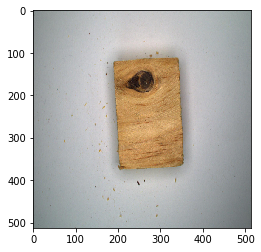

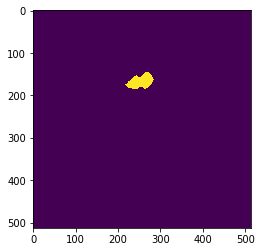

In [18]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.latest_checkpoint('./checkpoints/')
    if ckpt:
        saver.restore(sess,ckpt)
        print('restore from the checkpoint {0}'.format(ckpt))

    image = Image.open(validation_list[1])
    image = image.resize((513,513))
    test_image = np.asarray(image, dtype=np.float32)
    test_image = np.expand_dims(test_image,axis=0)
    test_image = test_image/255
    start = time.clock()
    [output] = sess.run([pred_classes],feed_dict={inputs:test_image})
    end = time.clock() - start
    print("Time elapsed: "+str(end))
#         result = np.squeeze(output)
    plt.imshow(image)
    plt.show()
    plt.imshow(output)
    plt.show()

In [41]:
image1 = np.asarray(image,dtype=np.uint16)

In [28]:
import cv2

In [64]:
label1 = np.asarray(output,dtype=np.uint16)

In [65]:
label1 = cv2.cvtColor(label1,cv2.COLOR_GRAY2RGB)

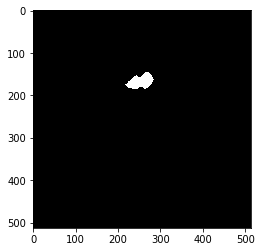

In [68]:
label1[label1!=0] =255
plt.imshow(label1)

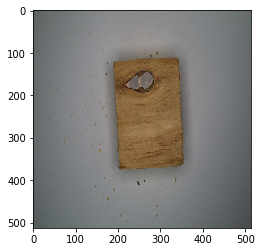

In [69]:
img_add = cv2.addWeighted(image1,0.7,label1,0.3,0)
plt.imshow(img_add)

INFO:tensorflow:Restoring parameters from ./checkpoints/Deeplab101-185100
restore from the checkpoint ./checkpoints/Deeplab101-185100
Time elapsed: 0.4738040000000012


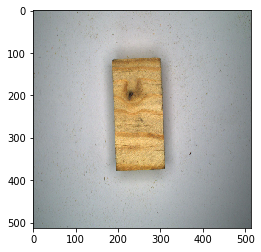

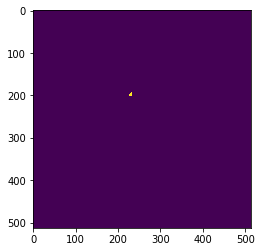

Time elapsed: 0.008535000000000181


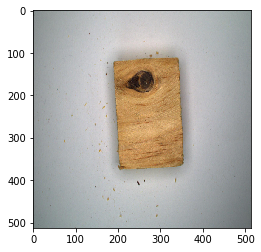

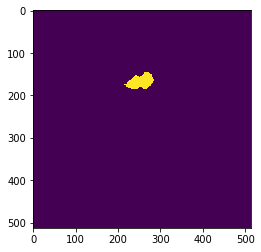

Time elapsed: 0.007876000000001326


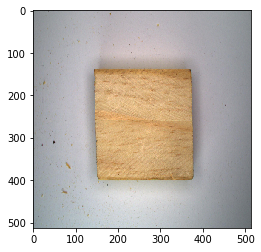

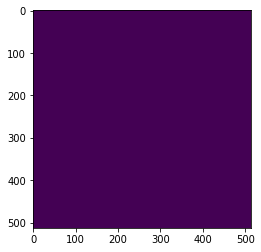

Time elapsed: 0.008825000000001637


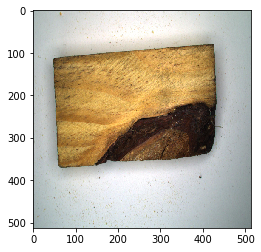

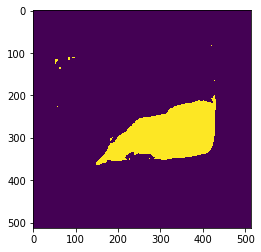

Time elapsed: 0.008427000000001073


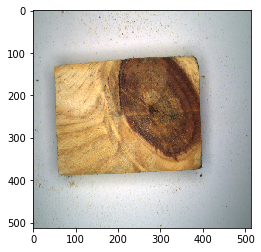

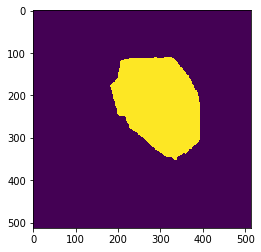

Time elapsed: 0.008093000000000572


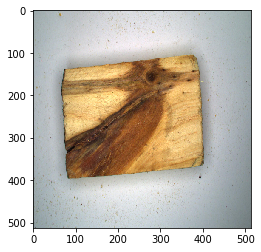

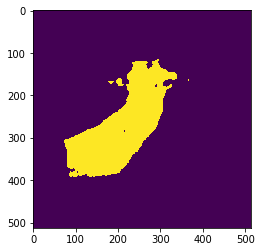

Time elapsed: 0.007828999999999198


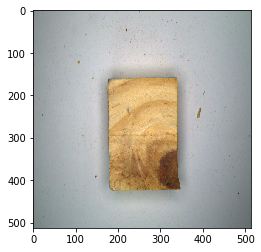

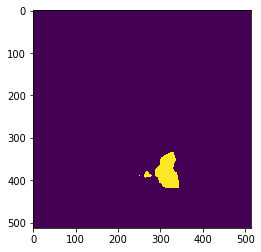

Time elapsed: 0.007800999999998837


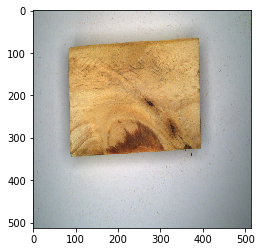

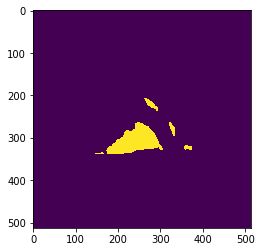

Time elapsed: 0.008547000000000082


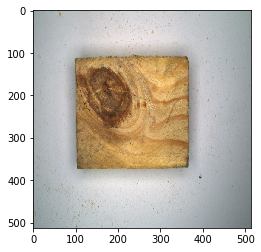

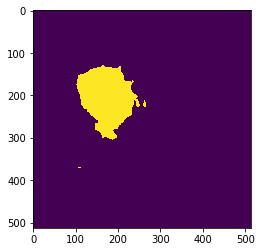

Time elapsed: 0.008713999999999444


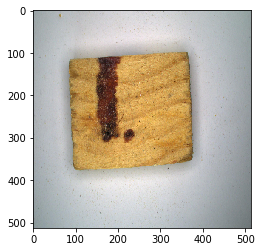

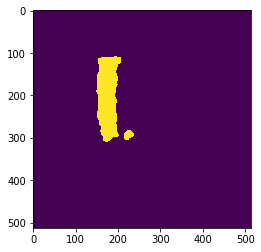

Time elapsed: 0.007797000000000054


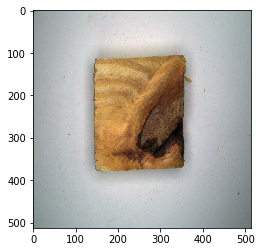

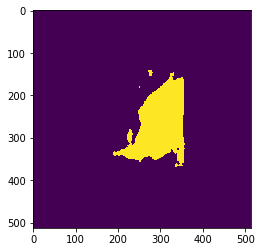

Time elapsed: 0.00832999999999906


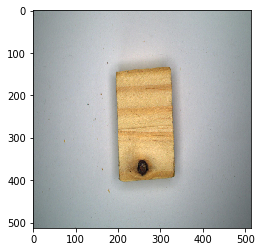

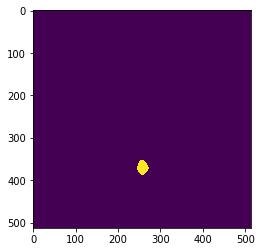

Time elapsed: 0.010412999999999784


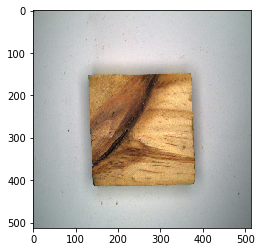

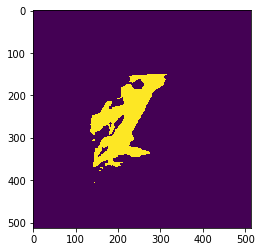

Time elapsed: 0.008081000000000671


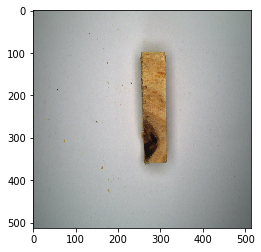

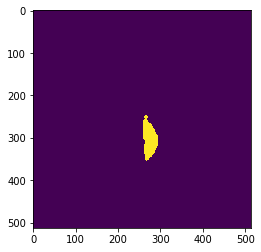

Time elapsed: 0.008281999999999456


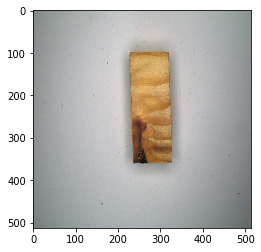

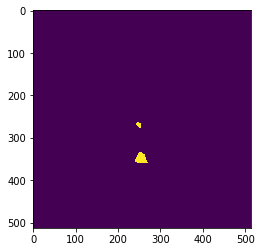

Time elapsed: 0.007977000000000345


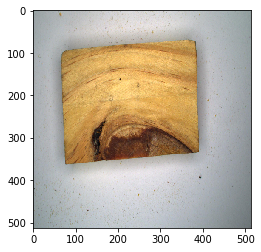

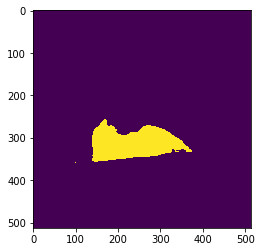

Time elapsed: 0.008126999999999995


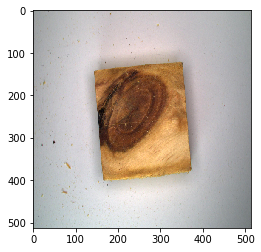

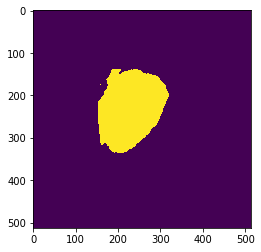

Time elapsed: 0.008236000000000132


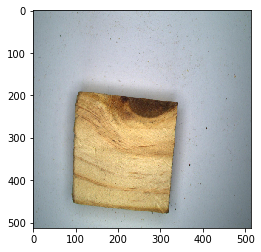

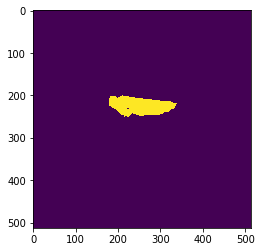

Time elapsed: 0.008632999999999669


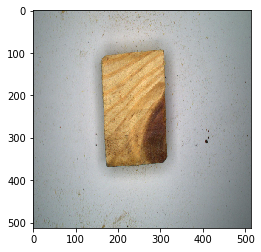

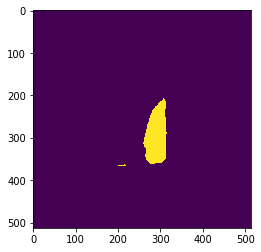

Time elapsed: 0.007909000000001498


KeyboardInterrupt: 

In [15]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.latest_checkpoint('./checkpoints/')
    if ckpt:
        saver.restore(sess,ckpt)
        print('restore from the checkpoint {0}'.format(ckpt))
    for i in validation_list:
        image = Image.open(i)
        image = image.resize((513,513))
        test_image = np.asarray(image, dtype=np.float32)
        test_image = np.expand_dims(test_image,axis=0)
        test_image = test_image/255
        start = time.clock()
        [output] = sess.run([pred_classes],feed_dict={inputs:test_image})
        end = time.clock() - start
        print("Time elapsed: "+str(end))
#         result = np.squeeze(output)
        plt.imshow(image)
        plt.show()
        plt.imshow(output)
        plt.show()
#         temp_label = np.squeeze(test_label)
#         temp_label[temp_label==255]=0
#         plt.imshow(temp_label)
#         plt.show()

In [70]:
output.shape

(513, 513)

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(np.squeeze(test_label))

In [ ]:
result[result == 255]

In [ ]:
test_label[test_label == 255] =0

In [ ]:
plt.imshow(np.squeeze(test_label))

In [ ]:
import os
import sys
from shutil import copyfile

In [ ]:
temp_dir ='/home/xinje/Desktop/tensorflow-deeplab-v3-plus/training_data/validation/'
original_dir = [temp_dir+i for i in os.listdir('./training_data/validation/')]
original_filelist = os.listdir('./training_data/validation/')

In [ ]:
if not os.path.exists('/home/xinje/Desktop/tensorflow-deeplab-v3-plus/training_data/validation2/'):
    os.mkdir('/home/xinje/Desktop/tensorflow-deeplab-v3-plus/training_data/validation2/')
for i in range(len(original_filelist)):
    copyfile(original_dir[i],'/home/xinje/Desktop/tensorflow-deeplab-v3-plus/training_data/validation2/'+str(i)+'.jpg')